# Logistic Regression Model

## Data Import And Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
from sklearn.preprocessing import StandardScaler

#reloads the module with the most recent updates
%load_ext autoreload
%aimport scripts.logistic_regression_functions, scripts.helper_functions
%autoreload 2

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

test_files = [ '../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']

x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 0

In [3]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


## Use Datetime Index

In [4]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [5]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [6]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


## Import And Clean Weather Data

In [7]:
weather = pd.read_csv('../../data/cleaned/daily_weather_metric_2017_2018.csv')
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,EVAP,MDPR,MNPN,...,TMAX,TMIN,TOBS,WESD,WESF,WT01,WT03,WT04,WT05,WT11
0,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/1/2017,NaN,NaN,NaN,NaN,...,18.9,7.2,13.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/2/2017,NaN,NaN,NaN,NaN,...,19.4,7.8,17.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/3/2017,NaN,NaN,NaN,NaN,...,21.7,4.4,21.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/4/2017,NaN,NaN,NaN,NaN,...,26.7,6.7,26.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/5/2017,NaN,NaN,NaN,NaN,...,31.7,8.9,30.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Find out how much of the data is missing for each column.
drop_columns = []
missing_threshold = .05
for column in weather.columns:
    number_null = np.sum(weather[column].isnull())
    column_length = len(weather[column])
    should_drop_column = (number_null / column_length) > missing_threshold
    print('{} percent null: {:.1f}%'.format(column, (number_null / column_length) * 100))
    if should_drop_column:
        drop_columns.append(column)
print('dropping columns: {}'.format(drop_columns))
weather = weather.drop(drop_columns, axis=1)

STATION percent null: 0.0%
NAME percent null: 0.0%
LATITUDE percent null: 0.0%
LONGITUDE percent null: 0.0%
ELEVATION percent null: 0.0%
DATE percent null: 0.0%
DAPR percent null: 99.7%
EVAP percent null: 50.6%
MDPR percent null: 99.7%
MNPN percent null: 50.9%
MXPN percent null: 50.9%
PRCP percent null: 0.9%
SNOW percent null: 0.5%
SNWD percent null: 0.5%
TAVG percent null: 100.0%
TMAX percent null: 0.2%
TMIN percent null: 0.0%
TOBS percent null: 0.5%
WESD percent null: 100.0%
WESF percent null: 100.0%
WT01 percent null: 100.0%
WT03 percent null: 99.5%
WT04 percent null: 100.0%
WT05 percent null: 100.0%
WT11 percent null: 100.0%
dropping columns: ['DAPR', 'EVAP', 'MDPR', 'MNPN', 'MXPN', 'TAVG', 'WESD', 'WESF', 'WT01', 'WT03', 'WT04', 'WT05', 'WT11']


In [9]:
# Drop the columns we will not be using.
weather = weather.drop(columns=['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION', 'TOBS'])

In [10]:
weather['DATE'] = pd.to_datetime(weather['DATE'])
# Set a datetime index for convenience
weather['timestamp'] = weather['DATE']
weather = weather.set_index('timestamp')
weather.dtypes

DATE    datetime64[ns]
PRCP           float64
SNOW           float64
SNWD           float64
TMAX           float64
TMIN           float64
dtype: object

In [11]:
weather['DATE'] = weather['DATE'].apply(lambda x: x.date())

In [12]:
count = 0
total = len(train_dfs + test_dfs)
for df in train_dfs + test_dfs:
    count += 1
    print("starting dataframe {}/{}".format(count, total))
    for column in weather.drop(columns='DATE').columns:
        print("adding series for column:", column)
        values = []
        old_datetime = None
        value = None
        for datetime in df['datetime']:
            datetime = datetime.date()
            if datetime != old_datetime:
                old_datetime = datetime
                value = weather[weather['DATE'] == datetime][column]
            values.append(value.values[0] if len(value.values) > 0 else np.nan)
        df[column] = values

starting dataframe 1/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 2/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 3/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 4/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN


### Import and Clean Wind Data

In [13]:
weather_files = ['../../data/raw_data/weather/provo_airport_2017', '../../data/raw_data/weather/provo_airport_2018']
# the array to store the readings in
contents = []

# Extract the weather data in the ISD format
for file in weather_files:
    contents.append(hf.extract_weather_data(file))


In [14]:
# the dfs containing the wind information for the readings.
wind_frame_2017 = pd.DataFrame(columns=["angle","speed"])
wind_frame_2018 = pd.DataFrame(columns=["angle","speed"])


wind_frames = [wind_frame_2017, wind_frame_2018]
for i in range(len(contents)):
    wind_dict = {}
    for reading in contents[i]:
        reading.GPO_timestamp = hf.round_time(reading.GPO_timestamp)

        # no key value made yet
        if reading.GPO_timestamp not in wind_dict.keys():
            # check to see if the readings are valid
            # Sets them to 'invalid' so that when we inpute them it can be handled
            if reading.WO_wind_angle == '999':
                reading.WO_wind_angle = np.nan
            else:
                reading.WO_wind_angle = int(reading.WO_wind_angle)
            if reading.WO_wind_speed == '9999':
                reading.WO_wind_speed = np.nan
            else:
                reading.WO_wind_speed = int(reading.WO_wind_speed)
            wind_dict[reading.GPO_timestamp] = [reading.WO_wind_angle, reading.WO_wind_speed]
    wind_frames[i] = pd.DataFrame.from_dict(wind_dict, orient='index')
    wind_frames[i] = wind_frames[i].rename(columns={0:'Wind Angle', 1:'Wind Speed'})

In [15]:
#we need to join the wind data now to the existing dataframes, but the dont care about

for i in range(len(train_dfs)):
    # train dfs is the 2017 data set so we need to set the wind frame to that 
    # dataset
    train_dfs[i] = train_dfs[i].join(wind_frames[0])
for i in range(len(test_dfs)):
    # test dfs is the 2018 data set so we need to set the wind frame to that
    # dataset
    test_dfs[i] = test_dfs[i].join(wind_frames[1])

In [16]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [17]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN


Need to deal with the NaNs in the dataframe for the WInd Angle and Wind Speed. There is a couple of ways that we can do this. One way is to assume that the wind doesn't change direction from the last valid responce (or the next in the case where the first entry is a NaN) or to assume that weather acts predictibly and will change direction and angle easily from entry to entry. 

I.E first entry 120 angle and 36 m/s speed, second (valid) entry 160 angle and 24 m/s speed slowing pan the angle inbetween and decrese the speed throughout so the entrries would look something like this:

From:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|NaN|NaN|
|2018-04-11 12:30:00|NaN|NaN|
|2018-04-11 12:45:00|NaN|NaN|
|2018-04-11 13:00:00|160|24|

To:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|130|33 |
|2018-04-11 12:30:00|140|30 |
|2018-04-11 12:45:00|150|27 |
|2018-04-11 13:00:00|160|24 |

In [18]:
for i in range(len(train_dfs)):
    train_dfs[i]['Wind Angle'] = train_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    train_dfs[i]['Wind Speed'] = train_dfs[i]['Wind Speed'].interpolate(limit_direction='both')
for i in range(len(test_dfs)):
    #test dfs is the 2018 data set so we need to set the wind frame to that dataset
    test_dfs[i]['Wind Angle'] = test_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    test_dfs[i]['Wind Speed'] = test_dfs[i]['Wind Speed'].interpolate(limit_direction='both')

In [19]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [20]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,255.0,55.5
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,210.0,49.0


##  Target Window Investigation
Here we will use a constant window size of 28 days to investigate model accuracy with increasing target window size

In [21]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
current_x_window = pd.Timedelta('28 days') # This remains constant for this test
current_y_window = pd.Timedelta(1, unit='d')
max_y_window = pd.Timedelta('14 days') # Predict if a bloom will occur within up to a 2 week window
current_separation = pd.Timedelta(0)
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window
accuracies = []
y_windows = []


max_iter = 25000
loss = "log"

while current_y_window <= max_y_window:
    
    # Windowize
    print("current y window", current_y_window)
    print("Windowizing 2017 data set:", train_index)
    train = hf.windowize(
        train_dfs[0], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window, 
        separation=current_separation)
    train = train.append(hf.windowize(
        train_dfs[1], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window, 
        separation=current_separation))
    print("Windowizing 2018 data set:", test_index)
    test = hf.windowize(
        test_dfs[0], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window,
        separation=current_separation)
    test = test.append(hf.windowize(
        test_dfs[1], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window,
        separation=current_separation))
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)
    
    # Sort columns by accuracy
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                                test,
                                                x_columns,
                                                'bloom', verbose=0)
    # Create greedy model
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
        model, train, test, x_columns,'bloom', sorted_columns)
    print("accuracy", accuracy)
    print("recall", recall)
    print("precision", precision)
    print("cm\n", cm)
    
    y_windows.append(current_y_window)
    accuracies.append(accuracy)
    current_y_window += iteration_delta

current y window 1 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7909698996655519
Test model recall: 0.7851458885941645
Test model precision: 0.8705882352941177

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7525083612040134
Test model recall: 0.6339522546419099
Test model precision: 0.9598393574297188

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.7909698996655519
Test model recall: 0.7851458885941645
Test model precision: 0.8705882352941177

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.8478260869565217
Test model recall: 0.907161803713527

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'Temp C', 'ODOSat%', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'ODO (mg/L)', 'Wind Angle', 'PRCP', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'Temp C', 'ODOSat%', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'ODO (mg/L)', 'Wind Angle', 'PRCP', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8097643097643098
Test model recall: 0.7888040712468194
Test model precision: 0.9117647058823529

Updating greedy model

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8383838383838383
Test model recall: 0.8575063613231552
Test model precision: 0.8938992042440318

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'ODOSat%']
Test model accuracy: 0.8215488215488216
Test model recall: 0.7455470737913485
Test model precision: 0.979933110367893

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.82154882154

Test model accuracy: 0.8758503401360545
Test model recall: 0.9027431421446384
Test model precision: 0.9141414141414141

Updating greedy model

Training model with: ['TMIN', 'PRCP', 'Temp C']
Test model accuracy: 0.8163265306122449
Test model recall: 0.8678304239401496
Test model precision: 0.8635235732009926

Training model with: ['TMIN', 'PRCP', 'ODOSat%']
Test model accuracy: 0.8537414965986394
Test model recall: 0.8029925187032418
Test model precision: 0.9787234042553191

Training model with: ['TMIN', 'PRCP', 'pH']
Test model accuracy: 0.8435374149659864
Test model recall: 0.942643391521197
Test model precision: 0.8456375838926175

Training model with: ['TMIN', 'PRCP', 'SNWD']
Test model accuracy: 0.8758503401360545
Test model recall: 0.9027431421446384
Test model precision: 0.9141414141414141

Training model with: ['TMIN', 'PRCP', 'SNOW']
Test model accuracy: 0.8758503401360545
Test model recall: 0.9027431421446384
Test model precision: 0.9141414141414141

Training model with: ['TM

Test model accuracy: 0.9086206896551724
Test model recall: 0.9176755447941889
Test model precision: 0.9522613065326633

Updating greedy model

Training model with: ['TMIN', 'rainy', 'SNOW']
Test model accuracy: 0.9086206896551724
Test model recall: 0.9176755447941889
Test model precision: 0.9522613065326633

Training model with: ['TMIN', 'rainy', 'pH (mV)']
Test model accuracy: 0.7293103448275862
Test model recall: 1.0
Test model precision: 0.724561403508772

Training model with: ['TMIN', 'rainy', 'Wind Speed']
Test model accuracy: 0.8982758620689655
Test model recall: 0.9200968523002422
Test model precision: 0.9359605911330049

Training model with: ['TMIN', 'rainy', 'ODO (mg/L)']
Test model accuracy: 0.8862068965517241
Test model recall: 0.8716707021791767
Test model precision: 0.9651474530831099

Training model with: ['TMIN', 'rainy', 'Wind Angle']
Test model accuracy: 0.7775862068965518
Test model recall: 0.7167070217917676
Test model precision: 0.961038961038961

Training model wit

Test model accuracy: 0.921602787456446
Test model recall: 0.9320843091334895
Test model precision: 0.961352657004831

Training model with: ['TMIN', 'rainy', 'PRCP', 'ODO (mg/L)']
Test model accuracy: 0.8832752613240418
Test model recall: 0.8805620608899297
Test model precision: 0.9591836734693877

Training model with: ['TMIN', 'rainy', 'PRCP', 'Sp Cond (uS/cm)']
Test model accuracy: 0.9198606271777003
Test model recall: 0.9578454332552693
Test model precision: 0.9359267734553776

Final greedy columns: ['TMIN', 'rainy', 'PRCP']
Final greedy accuracy 0.9250871080139372
Final greedy recall: 0.9672131147540983
Final greedy precision: 0.9343891402714932
Final greedy confusion matrix:
 [[118  29]
 [ 14 413]]
accuracy 0.9250871080139372
recall 0.9672131147540983
precision 0.9343891402714932
cm
 [[118  29]
 [ 14 413]]
current y window 9 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extr

Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

base_columns: []
sorted_columns: ['TMAX', 'Temp C', 'ODOSat%', 'Wind Speed', 'SNWD', 'rainy', 'Wind Angle', 'SNOW', 'pH', 'PRCP', 'TMIN', 'ODO (mg/L)', 'pH (mV)', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMAX', 'Temp C', 'ODOSat%', 'Wind Speed', 'SNWD', 'rainy', 'Wind Angle', 'SNOW', 'pH', 'PRCP', 'TMIN', 'ODO (mg/L)', 'pH (mV)', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['TMAX']
Test model accuracy: 0.8280141843971631
Test model recall: 0.9765807962529274
Test model precision: 0.8273809523809523

Updating greedy model

Training model with: ['TM

Test model accuracy: 0.8327338129496403
Test model recall: 1.0
Test model precision: 0.8238636363636364

Updating greedy model

Training model with: ['Temp C', 'Wind Speed']
Test model accuracy: 0.8201438848920863
Test model recall: 1.0
Test model precision: 0.8130841121495327

Training model with: ['Temp C', 'SNWD']
Test model accuracy: 0.8327338129496403
Test model recall: 1.0
Test model precision: 0.8238636363636364

Training model with: ['Temp C', 'ODOSat%']
Test model accuracy: 0.789568345323741
Test model recall: 0.9954022988505747
Test model precision: 0.7901459854014599

Training model with: ['Temp C', 'rainy']
Test model accuracy: 0.8812949640287769
Test model recall: 0.8666666666666667
Test model precision: 0.9792207792207792

Updating greedy model

Training model with: ['Temp C', 'rainy', 'TMAX']
Test model accuracy: 0.8561151079136691
Test model recall: 0.8275862068965517
Test model precision: 0.9863013698630136

Training model with: ['Temp C', 'rainy', 'Wind Angle']
Test m

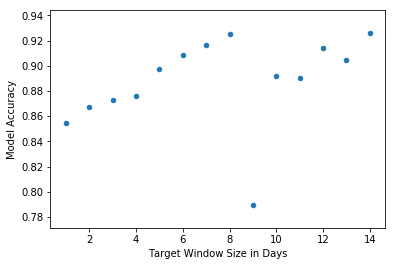

In [24]:
# Plot the accuracies vs y_window size
windows = [x.days for x in y_windows]
x = "Target Window Size in Days"
y = "Model Accuracy"
df = pd.DataFrame({y: accuracies, 
                       x: windows})
df.plot(kind="scatter", y=y, x=x)

##  Target Separation Investigation
Here we will use a constant x window size of 28 days to investigate model accuracy with increasing target separation size

In [25]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
current_x_window = pd.Timedelta('28 days') # This remains constant for this test
current_y_window = pd.Timedelta(1, unit='d') # This remains constant for this test
max_separation = pd.Timedelta('13 days') # Predict the last 24 hours in a 2 week span
current_separation = pd.Timedelta(0)
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window
accuracies = []
separations = []


max_iter = 25000
loss = "log"

while current_separation <= max_separation:
    
    # Windowize
    print("current separation", current_separation)
    print("Windowizing 2017 data set:", train_index)
    train = hf.windowize(
        train_dfs[0], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window, 
        separation=current_separation)
    train = train.append(hf.windowize(
        train_dfs[1], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window, 
        separation=current_separation))
    print("Windowizing 2018 data set:", test_index)
    test = hf.windowize(
        test_dfs[0], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window,
        separation=current_separation)
    test = test.append(hf.windowize(
        test_dfs[1], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window,
        separation=current_separation))
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)
    
    # Sort columns by accuracy
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                                test,
                                                x_columns,
                                                'bloom', verbose=0)
    # Create greedy model
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
        model, train, test, x_columns,'bloom', sorted_columns)
    print("accuracy", accuracy)
    print("recall", recall)
    print("precision", precision)
    print("cm\n", cm)
    
    separations.append(current_separation)
    accuracies.append(accuracy)
    current_separation += iteration_delta

current separation 0 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7909698996655519
Test model recall: 0.7851458885941645
Test model precision: 0.8705882352941177

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7525083612040134
Test model recall: 0.6339522546419099
Test model precision: 0.9598393574297188

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.7909698996655519
Test model recall: 0.7851458885941645
Test model precision: 0.8705882352941177

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.8478260869565217
Test model recall: 0.907161803713527

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'TMAX', 'pH', 'ODO (mg/L)', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'TMAX', 'pH', 'ODO (mg/L)', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7962962962962963
Test model recall: 0.7983651226158038
Test model precision: 0.861764705882353

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7946127946127947
Test model recall: 0.7002724795640327
Test model precision: 0.9553903345724907

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8013468013468014
Test model recall: 0.8065395095367848
Test model precision: 0.8629737609329446

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'TMAX']
Test model accuracy: 0.7996632996632996
Te

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'Temp C', 'ODOSat%', 'TMAX', 'pH', 'Wind Speed', 'pH (mV)', 'ODO (mg/L)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'Temp C', 'ODOSat%', 'TMAX', 'pH', 'Wind Speed', 'pH (mV)', 'ODO (mg/L)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8152542372881356
Test model recall: 0.8130081300813008
Test model precision: 0.8823529411764706

Updating greedy model

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8169491525423729
Test model recall: 0.8617886178861789
Test model precision: 0.848

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'ODOSat%']
Test model accuracy: 0.8457627118644068
Test model recall: 0.8075880758807588
Test model precision: 0.9371069182389937

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'ODOSat%', 'TMAX']
Test model

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'Temp C', 'ODOSat%', 'TMAX', 'pH', 'ODO (mg/L)', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Wind Angle', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'Temp C', 'ODOSat%', 'TMAX', 'pH', 'ODO (mg/L)', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Wind Angle', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8061224489795918
Test model recall: 0.798941798941799
Test model precision: 0.888235294117647

Updating greedy model

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8061224489795918
Test model recall: 0.798941798941799
Test model precision: 0.888235294117647

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.8095238095238095
Test model recall: 0.7301587301587301
Test model precision: 0.965034965034965

Updating greedy model

Training model with: ['TMIN', 'ODOSat%', 'TMAX']
Test model accuracy: 0.7755102040816326
Test 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'Temp C', 'TMAX', 'ODOSat%', 'pH', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'pH (mV)', 'Wind Angle', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'Temp C', 'TMAX', 'ODOSat%', 'pH', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'pH (mV)', 'Wind Angle', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8202054794520548
Test model recall: 0.816711590296496
Test model precision: 0.8911764705882353

Updating greedy model

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8202054794520548
Test model recall: 0.816711590296496
Test model precision: 0.8911764705882353

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.761986301369863
Test model recall: 0.7115902964959568
Test model precision: 0.8918918918918919

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.8202054794520548
Test model recall: 0.816711590296496


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'pH', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'Wind Angle', 'SNOW', 'pH (mV)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'pH', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'Wind Angle', 'SNOW', 'pH (mV)', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8241379310344827
Test model recall: 0.8233695652173914
Test model precision: 0.8911764705882353

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7586206896551724
Test model recall: 0.7038043478260869
Test model precision: 0.8931034482758621

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8241379310344827
Test model recall: 0.8233695652173914
Test model precision: 0.8911764705882353

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.8172413793103448
Test model recall: 0.8125
Test mod

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'pH', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'Wind Angle', 'SNOW', 'pH (mV)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'pH', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'Wind Angle', 'SNOW', 'pH (mV)', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.830155979202773
Test model recall: 0.8218085106382979
Test model precision: 0.9088235294117647

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7504332755632582
Test model recall: 0.7021276595744681
Test model precision: 0.8918918918918919

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.830155979202773
Test model recall: 0.8218085106382979
Test model precision: 0.9088235294117647

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.830155979202773
Test model recall: 0.8218085106382979

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'pH', 'rainy', 'Turbidity (NTU)', 'SNWD', 'Wind Angle', 'SNOW', 'pH (mV)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'pH', 'rainy', 'Turbidity (NTU)', 'SNWD', 'Wind Angle', 'SNOW', 'pH (mV)', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8275261324041812
Test model recall: 0.8196286472148541
Test model precision: 0.9088235294117647

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7578397212543554
Test model recall: 0.7082228116710876
Test model precision: 0.902027027027027

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8275261324041812
Test model recall: 0.8196286472148541
Test model precision: 0.9088235294117647

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.8101045296167247
Test model recall: 0.78779840848806

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'SNWD', 'ODO (mg/L)', 'SNOW', 'pH', 'pH (mV)', 'Wind Angle', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'SNWD', 'ODO (mg/L)', 'SNOW', 'pH', 'pH (mV)', 'Wind Angle', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8298245614035088
Test model recall: 0.8310626702997275
Test model precision: 0.8970588235294118

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7701754385964912
Test model recall: 0.7193460490463215
Test model precision: 0.9041095890410958

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8298245614035088
Test model recall: 0.8310626702997275
Test model precision: 0.8970588235294118

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7912280701754386
Test model recall: 0.8065395095367

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'ODO (mg/L)', 'SNOW', 'pH', 'pH (mV)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'ODO (mg/L)', 'SNOW', 'pH', 'pH (mV)', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8392226148409894
Test model recall: 0.8373983739837398
Test model precision: 0.9088235294117647

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7862190812720848
Test model recall: 0.7317073170731707
Test model precision: 0.9246575342465754

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.823321554770318
Test model recall: 0.8834688346883469
Test model precision: 0.8511749347258486

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7862190812720848
Test model recall: 0.79945799457994

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'ODO (mg/L)', 'SNOW', 'pH (mV)', 'pH', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'ODO (mg/L)', 'SNOW', 'pH (mV)', 'pH', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8404255319148937
Test model recall: 0.8306878306878307
Test model precision: 0.9235294117647059

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.776595744680851
Test model recall: 0.7195767195767195
Test model precision: 0.9315068493150684

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8439716312056738
Test model recall: 0.8809523809523809
Test model precision: 0.8856382978723404

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'ODOSat%']
Test model accuracy: 0.7890070921985816
Te

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.32978723404255317
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.6453900709219859
Test model recall: 0.49206349206349204
Test model precision: 0.9587628865979382

Training model with: ['TMIN', 'Temp C', 'Sp Cond (uS/cm)']
Test model accuracy: 0.524822695035461
Test model recall: 0.328042328042328
Test model precision: 0.8985507246376812

Final greedy columns: ['TMIN', 'Temp C']
Final greedy accuracy 0.8439716312056738
Final greedy recall: 0.8809523809523809
Final greedy precision: 0.8856382978723404
Final greedy confusion matrix:
 [[143  43]
 [ 45 333]]
accuracy 0.8439716312056738
recall 0.8809523809523809
precision 0.8856382978723404
cm
 [[143  43]
 [ 45 333]]
current separation 11 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'ODO (mg/L)', 'SNOW', 'pH (mV)', 'pH', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'ODOSat%', 'PRCP', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'ODO (mg/L)', 'SNOW', 'pH (mV)', 'pH', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8410714285714286
Test model recall: 0.8382749326145552
Test model precision: 0.9147058823529411

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7732142857142857
Test model recall: 0.7277628032345014
Test model precision: 0.9121621621621622

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8517857142857143
Test model recall: 0.894878706199461
Test model precision: 0.8829787234042553

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'ODOSat%']
Test model accuracy: 0.7785714285714286
Te

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.3375
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.6160714285714286
Test model recall: 0.4420485175202156
Test model precision: 0.9534883720930233

Training model with: ['TMIN', 'Temp C', 'Sp Cond (uS/cm)']
Test model accuracy: 0.4142857142857143
Test model recall: 0.3018867924528302
Test model precision: 0.6187845303867403

Final greedy columns: ['TMIN', 'Temp C']
Final greedy accuracy 0.8517857142857143
Final greedy recall: 0.894878706199461
Final greedy precision: 0.8829787234042553
Final greedy confusion matrix:
 [[145  44]
 [ 39 332]]
accuracy 0.8517857142857143
recall 0.894878706199461
precision 0.8829787234042553
cm
 [[145  44]
 [ 39 332]]
current separation 12 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining ext

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'PRCP', 'ODOSat%', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'ODO (mg/L)', 'Wind Angle', 'SNWD', 'SNOW', 'pH (mV)', 'pH', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'PRCP', 'ODOSat%', 'Wind Speed', 'rainy', 'Turbidity (NTU)', 'ODO (mg/L)', 'Wind Angle', 'SNWD', 'SNOW', 'pH (mV)', 'pH', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8453237410071942
Test model recall: 0.845108695652174
Test model precision: 0.9147058823529411

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7985611510791367
Test model recall: 0.7445652173913043
Test model precision: 0.9383561643835616

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8489208633093526
Test model recall: 0.907608695652174
Test model precision: 0.8697916666666666

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'PRCP']
Test model accuracy: 0.7320143884892086
Test m

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.3381294964028777
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.49280575539568344
Test model recall: 0.25
Test model precision: 0.9387755102040817

Training model with: ['TMIN', 'Temp C', 'Sp Cond (uS/cm)']
Test model accuracy: 0.2931654676258993
Test model recall: 0.20108695652173914
Test model precision: 0.4277456647398844

Final greedy columns: ['TMIN', 'Temp C']
Final greedy accuracy 0.8489208633093526
Final greedy recall: 0.907608695652174
Final greedy precision: 0.8697916666666666
Final greedy confusion matrix:
 [[138  50]
 [ 34 334]]
accuracy 0.8489208633093526
recall 0.907608695652174
precision 0.8697916666666666
cm
 [[138  50]
 [ 34 334]]
current separation 13 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining ext

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'PRCP', 'ODOSat%', 'rainy', 'Turbidity (NTU)', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'SNWD', 'SNOW', 'pH (mV)', 'pH', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'TMAX', 'Temp C', 'PRCP', 'ODOSat%', 'rainy', 'Turbidity (NTU)', 'ODO (mg/L)', 'Wind Speed', 'Wind Angle', 'SNWD', 'SNOW', 'pH (mV)', 'pH', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8553345388788427
Test model recall: 0.8457446808510638
Test model precision: 0.9352941176470588

Updating greedy model

Training model with: ['TMIN', 'TMAX']
Test model accuracy: 0.7938517179023508
Test model recall: 0.7313829787234043
Test model precision: 0.9548611111111112

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8607594936708861
Test model recall: 0.925531914893617
Test model precision: 0.8765743073047859

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'PRCP']
Test model accuracy: 0.7504520795660036
Test 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.32007233273056057
Test model recall: 0.0
Test model precision: 0.0

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.47920433996383366
Test model recall: 0.24468085106382978
Test model precision: 0.9583333333333334

Training model with: ['TMIN', 'Temp C', 'Sp Cond (uS/cm)']
Test model accuracy: 0.36347197106690776
Test model recall: 0.31648936170212766
Test model precision: 0.5560747663551402

Final greedy columns: ['TMIN', 'Temp C']
Final greedy accuracy 0.8607594936708861
Final greedy recall: 0.925531914893617
Final greedy precision: 0.8765743073047859
Final greedy confusion matrix:
 [[128  49]
 [ 28 348]]
accuracy 0.8607594936708861
recall 0.925531914893617
precision 0.8765743073047859
cm
 [[128  49]
 [ 28 348]]


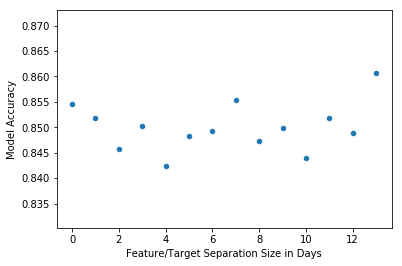

In [27]:
# Plot the accuracies vs y_window size
seps = [x.days for x in separations]
x = "Feature/Target Separation Size in Days"
y = "Model Accuracy"
df = pd.DataFrame({y: accuracies, 
                       x: seps})
df.plot(kind="scatter", y=y, x=x)